In [74]:
#Imports:
import pandas as pd
import numpy as np
from collections import Counter
import pandas as pd
import scipy.stats as stats
import os as os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import functools as fct
import seaborn as sns
import itertools as it
import scipy as sci
import math as mt
from pytablewriter import MarkdownTableWriter
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
import statsmodels.api as sm
from copy import deepcopy

from statsmodels.distributions.empirical_distribution import ECDF
import pandas_profiling as pdp
import io

data_source_dir = '/Users/nhamlett/Documents/GitHub/GA-DSI/project/project_1/data'



In [4]:
#
# Partition a list into a specified number of bins.  Our inputs
# are:
# ⧐ parted_list is the list to be partitioned;
# ⧐ partition_counts specifies the number of bins into which
#   parted_list is divided.
# We produce an enumerated dictionary of the list partitions.
def partition_list(parted_list, partition_counts):
    parted_list = np.sort(np.array(parted_list))
    partition_len = int(np.ceil(len(parted_list)/partition_counts))
    partitions = [np.array(object = range(partition_len)) + part * partition_len
                     for part in range(partition_counts)]
    partitions[-1] = np.arange(start = partitions[-1][0],
                               stop = parted_list.shape[0])
    return dict(enumerate([list(parted_list[part])
                             for part in partitions]))
#
# CALCULATE ANALYSIS-OF-VARIANCE (ANOVA) STATISTICS for a given
# observation-estimate pair.  We calculate Total Sum of Suares,
# Error Sum of Squaresm, Regression Sum of Squares, and 
# coefficient of deternination in accordance with 
# [Dielman, 2005, pp. 94 - 96].
def anova(y_observed, y_estimated):
    # Total sum of squares.
    SST = np.square(y_observed - y_observed.mean()).sum()
    #
    # Error sum of squares.
    SSE = np.square(y_observed - y_estimated ).sum()
    #
    # Regression sum of squares.
    SSR = np.square(y_estimated - y_observed.mean()).sum()
    #
    # Coefficient of determination.
    R2 = 1 - SSE/SST
    #
    return {'root_SST' : np.sqrt(SST),
            'root_SSE' : np.sqrt(SSE),
            'root_SSR' : np.sqrt(SSR),
            'SST-SSE-SSR' : SST - SSE - SSR,
            'R2' : R2}
#
# Generate a 2×2 grid of Response, Residual plots. Our inputs are:
# ⧐ y_train, a vector training-data-set observed, response variables;
# ⧐ y_test, a vector test-data-set observed, response variables;
# ⧐ fit_train, a vector training-data-set estimated, response variables;
# ⧐ fit_test, a vector test-data-set estimated, response variables; and
# ⧐ plot_title, a text string for the "suptitle" label.
def response_residual_plots(y_test, y_train, fit_test, fit_train, plot_title):
    # Encapsulate our inputs into a dictionary. This makes managing simpler
    # with subsequent control loops.
    resp_resid = {'y_train' : y_train,
                  'y_test' : y_test,
                  'fit_train' : fit_train,
                  'fit_test' : fit_test,
                  'resid_train' : y_train - fit_train,
                  'resid_test' : y_test - fit_test}
    #
    # Initialize the plot.  We define a 2×2 subplot arrangement.  Encapsulate our
    # labels and plot axes into dictionaries.
    fig, axes = plt.subplots(2, 2, figsize = (12, 9))
    plt_axes = dict(enumerate(np.ndarray.flatten(axes)))
    title_params = dict(enumerate(it.product(['Response', 'Residual'],
                                             ['training', 'test'])))
    yaxis_labels = dict(enumerate(2 * ['Estimate, $\hat{y}_i$'] + 2 * ['Residual, $\epsilon_i$']))
    xaxis_labels = dict(enumerate(2 * ['Observed, $y_i$'] + 2 * ['Estimated, $\hat{y}_i$']))
    #
    # Construct an enumerated dictionary specifying our paired plots.
    plot_var_pairs = dict(enumerate([('y_train', 'fit_train'),
                                     ('y_test', 'fit_test'),
                                     ('fit_train', 'resid_train'),
                                     ('fit_test', 'resid_test')]))
    #
    # Now, cycle through each plot axis and instantiate the plot.
    for axis_idx in plt_axes.keys():
        # According to [Olive, 2017] we want to compare our scatters with
        # an identity line or horizontal-axis line for response, residuals,
        # respectively.  Conditionally instantiate these features.
        if title_params.get(axis_idx)[0] == 'Residual':
            plt_axes.get(axis_idx).axhline(color = '#e8000daa',
                                           label = '$\epsilon_i = 0$')
            # Plot the scatter plots.
            plt_axes.get(axis_idx).scatter(resp_resid.get(plot_var_pairs.get(axis_idx)[0]),
                                           resp_resid.get(plot_var_pairs.get(axis_idx)[1]),
                                           color = '#2767ff',
                                           s = 2,
                                           label = '$(\hat{y}_i,\,\epsilon_i)$')
            #
        else:
            plt_axes.get(axis_idx).plot([0, min(max(resp_resid.get(plot_var_pairs.get(axis_idx)[0])),
                                                max(resp_resid.get(plot_var_pairs.get(axis_idx)[1])))],
                                        [0, min(max(resp_resid.get(plot_var_pairs.get(axis_idx)[0])),
                                                max(resp_resid.get(plot_var_pairs.get(axis_idx)[1])))],
                                        color = '#e8000daa',
                                        label = '$\hat{y}_i = y_i$')
            # Plot the scatter plots.
            plt_axes.get(axis_idx).scatter(resp_resid.get(plot_var_pairs.get(axis_idx)[0]),
                                           resp_resid.get(plot_var_pairs.get(axis_idx)[1]),
                                           color = '#2767ff',
                                           s = 2,
                                           label = '$(y_i,\,\hat{y}_i)$')
            #
        # Add a LOWESS curve.
        resp_lowess = sm.nonparametric.lowess
        lowess_curve =  resp_lowess(endog = resp_resid.get(plot_var_pairs.get(axis_idx)[1]),
                                    exog = resp_resid.get(plot_var_pairs.get(axis_idx)[0]))
        plt_axes.get(axis_idx).plot(lowess_curve[:,0],
                                    lowess_curve[:,1],
                                    color = '#f2a900',
                                    label = 'LOWESS')
        #
        # Apply plot labels.
        plt_axes.get(axis_idx).set_title(label = '{} plot, {} data'\
                                                    .format(*title_params.get(axis_idx)),
                                         color = '#0051ba')
        plt_axes.get(axis_idx).set_xlabel(xlabel = xaxis_labels.get(axis_idx))
        plt_axes.get(axis_idx).set_ylabel(ylabel = yaxis_labels.get(axis_idx))
#         plt_axes.get(axis_idx).legend(loc = 'lower right',
#                                       edgecolor = '#003459')
        #
    # Apply the plot super title.
    plt.suptitle(t = plot_title,
                 va = 'top',
                 y = .9675,
                 color = '#003459',
                 fontsize = 16);
    fig.subplots_adjust(wspace = 0.25)
    fig.subplots_adjust(hspace = 0.2625)
    return
#
# Perform manual cross-validation.  Particularly when we have
# categorical explanatory variables with large numbers of categories,
# we may get singularities in the sum-squares and -cross-roducts
# SSCP matrix. The 'canned' sklearn.model_selection.cros_val_score  
# fails to check for this. Here, we drop from our explanatory-
# variable data matrix attributes for which we have no
# finite values.  This provides for a stable model.
#
# Our inputs are:
# ⧐ X is the matrix of explanatory variables;
# ⧐ y is the observed response variables corresponding to X; and
# ⧐ cv is the number of cross-validation folds to perform.
#
# We return a dictionary with the ANOVA statistics for each.
#
def manual_cross_val_anova(X, y, cv):
    # ⓵ Partition the explanatory-variable dataframe indices into
    #    "cv" partions.  We have to account for the occurrence
    #    of an uneven partitions, if the length of our
    #    data matrix is a noninteger multiple of our "cv".
    X = X.reset_index(drop = True)
    y = y.reset_index(drop = True)
    part_len = int(np.ceil(len(X)/cv))
    partitions = [np.array(object = range(part_len)) + part * part_len
                     for part in range(cv)]
    partitions[-1] = np.arange(start = partitions[-1][0],
                               stop = X.shape[0])
    partitions = dict(enumerate(partitions))
    cross_val_anova = dict()
    # estimator.set_params(fit_intercept = True)
    #
    # ⓶ Now cycle through each partition.  The indices in each
    #    partition comprise our test data set.  So we drop those
    #    indices for the training set.  
    #    ⓐ Explicitly instantiate test and training data sets.
    part_idx = list(partitions.keys())[-1]
    for part_idx in partitions.keys():
        X_train = X.drop(labels = partitions.get(part_idx),
                         axis = 0)\
                   .assign(intercept = 1)
        y_train = y.drop(labels = partitions.get(part_idx),
                         axis = 0)
        X_test = X.loc[partitions.get(part_idx)]\
                   .assign(intercept = 1)
        y_test = y.loc[partitions.get(part_idx)]
        #
        #    ⓑ Identify columns in X_train for which all values are nonzero.
        #       We sum down the columns and check for nonzero results.
        #       This boolean result allows us to index into the columns
        #       of X_train to get the columns with nonzero vaues.
        finite_train_attributes = X_train.columns[(X_train.sum(axis = 0)!=0)]
        #
        #    ⓒ Train the model to the X_train, y_train, using only the
        #       finite-valued columns in the former.
        beta = sci.linalg.lstsq(a = X_train[finite_train_attributes],
                               b = y_train)[0]
        #estimator.fit(X = X_train[finite_train_attributes],
        #              y = y_train);
        #
        #    ⓓ Now, pass the predictions using X_test
        #       to the locally-defined function anova. Add the results to
        #       our dictionary cross_val_anova using the dictionary.update method.
        cross_val_anova.update(
            {part_idx : anova(y_estimated = np.dot(a = X_test[finite_train_attributes],
                                                   b = beta),
                              y_observed = y_test)})
    return cross_val_anova


<font color = '#0051ba'>

##  Data Cleansing and Exploratory Data Analysis (EDA).

</font>

🅐 DATA CLEANSING.

Our data cleansing and EDA result from an iterative process. This documentation begins after the first iteration.  Specifically, we describe undocumented activities performed during previous iterations.

This includes analysis documented in our data dictionary [(data_dictionary_populated.csv)](https://git.generalassemb.ly/hamlett-neil-ga/project_2/blob/master/datasets/data_dictionary_populated.csv). Or data dictionary is read in in cell 🅑, below.  We constructed it by annotating a template created by applying the pandas.DataFrame.info() method to our raw data from the [train.csv](https://git.generalassemb.ly/hamlett-neil-ga/project_2/blob/master/datasets/train.csv) "raw" data file.

Our data dictionary includes attribute information from the [data_description.txt](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) file at the Kagggle website. We transferred this information into the *Notes* column of our data dictionary. We reviewed the data attribute-by-attribute. We identified each attribute as categorical, numerical, or unique ID (primary key). 

Our data dictionary also contains a *disposition* column.  This contains judgements about the disposition of records — or of overall atrributes themselves — based completeness, other conditions.  Based on these pieces of information in the data dictionary, we are able to apply our cleansing actions using python logic.

This analysis influenced some of the specifications used by the `pandas.read_csv()` method to read in the raw data set [train.csv](https://git.generalassemb.ly/hamlett-neil-ga/project_2/blob/master/datasets/train.csv).  Specifically, the string `NA` is extensively used for "not applicable."  Pandas' default behavior is to interpret this as `Null`. So we select `keep_default_na = False` to inhibit this behavior.  We find in our csv file — through visual inspection in a text editor — that missing values are actually blanks `''`. We therefore specify the option `na_values = ['']` in our `pandas.read_csv()` statement.

In [5]:
# Read in the data.  Immediately upon reading, rename of the columns, 
# replacing spaces in column names with underbars. We do this because spaces
# in column names are inconvenient, if not downright evil 👹👺😈
housing_raw = pd.read_csv(filepath_or_buffer = './datasets/train.csv',
                          keep_default_na = False,
                          na_values = ['']).set_index(keys = 'PID',
                                                          drop = False)
housing_raw.rename(columns = dict(zip(housing_raw.columns,
                                       housing_raw.columns.str.replace(' ',''))),
                   inplace = True)
housing_raw.rename(columns = dict(zip(housing_raw.columns,
                                       housing_raw.columns.str.replace('/',''))),
                   inplace = True)

In [6]:
# Construct *Date_sold* attribute. Our raw data (train.csv) contains distinct 
# attributes for year sold and month sold. We want our sell date to be a 
# serial numeric variable. Converting it explicitly to a datetime object
# is inconvenient. Datetime objects present difficulties in plotting and as
# explanatory variables for regression.
#
# We instead create a YYYYMM attribute and call it "Sell_date". This takes 
# a wee bit of string-manipulation work.  We first concatenate Yr_Sold and
# Mo_Sold as strings.  We then convert the results back to a numeric.
# The built-in function "zfill" provides a very-convenient way to prepend 
# zeros to our single-digit months.
housing_raw = housing_raw.assign(Sell_date = lambda Ξ : [int(str(yr) + str(mo).zfill(2))
                                    for (yr, mo) in Ξ[['YrSold', 'MoSold']].to_records(index = False)])

In [7]:
# Use substrings in notes to classify attribute type as either
# numeric, discrete, categorical, or ID.  This operates on the
# "Notes" attribute of the data dictionary.
def classify_attribute(note):
    if 'Categorical'.lower() in note.lower():
        return 'Categorical'
    elif 'Discrete'.lower() in note.lower():
        return 'Discrete' 
    elif 'Numeric'.lower() in note.lower():
        return 'Continuous'
    elif 'target' in note.lower():
        'Target'
    else:
        return 'Primary_key'

In [8]:
%%capture
# 🅑 CONSTRUCT DATA DICTIONARY.
# We want to parse the pandas.DataFrame.info()  output so as to create
# an structured object that can be exported into a csv for use as a 
# data dictionary. 
#
# We use the io.StringIO() method to "scrape" the printed output into 
# a single character string. We then perform a series of splits.
# ⓵ We split by the new-line character "\n" and get a list of
#    substrings, each of which corresponds to a set of metadata
#    about an attribute.
# ⓶ We truncate the first two and last two substrings. These contain
#    output-object explanatory information that doesn't concern us.
# ⓷ Next, we split each of these substrings by a single space.  We keep
#    non-zero-length sub-substrings from each of the substrings. Since
#    we had the foresight to replace all spaces in our attribute names
#    with underscores, we have a regular list.
# ④ Capture the results into a pandas.DataFrame() object and write to csv.
# ⓹ Read in the modified data dictionary.
buffer = io.StringIO()
housing_raw.info(buf = buffer)
s = buffer.getvalue()
housing_profile_info = pd.merge(left = pd.DataFrame(data = [[substring
                                                              for substring in string_line.split(' ')
                                                              if len(substring) > 0]
                                                                for string_line in s.split('\n')[3:-3]],
                                                columns = ['attribute_name','non_null_records',
                                                           'non_null', 'type'])\
                                        .drop(labels = 'non_null',
                                              axis = 1)\
                                        .set_index(keys = 'attribute_name'),
                                right = pd.DataFrame(data = housing_raw.apply(func = lambda ζ : len(set(ζ)),
                                                                                  axis = 0),
                                                     columns = ['distinct_values']),
                                left_index = True,
                                right_index = True).assign(Notes = '')\
                                                   .rename_axis(index = 'attribute')
housing_profile_info.to_csv(path_or_buf = os.path.join('./datasets',
                                                       'data_dictionary_template.csv'),
                            index = True)
#
# ⓺ Read in the modified data dictionary.
data_dict_populated = pd.read_csv(filepath_or_buffer = os.path.join('./datasets',
                                                                    'data_dictionary_populated.csv'))\
                                    .fillna(value = 'Use as provided')\
                                    .assign(cat_vars = lambda Ξ : [classify_attribute(note)
                                                                         for note in Ξ['Notes']])

data_dict_md_writer = MarkdownTableWriter()
data_dict_md_writer.tabel_name = 'Aimes, IA Housing-Data Quality Assessment'           # Construct markdown table in
data_dict_md_writer.headers = data_dict_populated.columns.tolist()                    # accordance with package
data_dict_md_writer.value_matrix = np.ndarray.tolist(data_dict_populated.to_numpy())  # documentation.
data_dict_md_writer.write_table()


<font color = '#0051ba'>

We now do the data cleansing. We identified two attributes — `Lot_Frontage` and `Garage_Yr_Blt` — to be discarded. These attributes have substatial portions of missing values.  `Garage_Yr_Blt` in particular is very-closely correlated with `YearBuilt` attribute.  No obvious approach to attributing value to `Lot_Frontage` occurs.  We identified a small number of records for which no obvious approach to attributing missing values occured.

We use `pandas.DataFrame.dropna()` method to discard records. We select the records by specifying the `subset` option. Our `subset` is indicated by the presence of a `Drop record` statement in the `disposition` column of `data_dict_populated`. 

We drop attributes using the `pandas.DataFrame.drop(axis = 1)` method.
               
</color>

In [9]:
# Discard attributes.   
discarded_attributes =\
data_dict_populated.set_index(keys = 'attribute')\
                   .loc[['Discard attribute' in disposition 
                         for disposition in data_dict_populated['Disposition']]]\
                   .index\
                   .tolist()

print(discarded_attributes)
housing_profile = housing_raw.drop(labels = discarded_attributes,
                                   axis = 1)

['GarageYrBlt', 'LotFrontage']


In [117]:
# Discard attributes
discarded_attributes =\
data_dict_populated.set_index(keys = 'attribute')\
                   .loc[['Discard attribute' in disposition 
                         for disposition in data_dict_populated['Disposition']]]\
                   .index\
                   .tolist()
discarded_records =\
data_dict_populated.set_index(keys = 'attribute')\
                   .loc[['Discard records' in disposition 
                         for disposition in data_dict_populated['Disposition']]]\
                   .index\
                   .tolist()

#
# Cleans, transform data.
housing_profile = housing_raw.dropna(axis = 0,
                                     how = 'any',
                                     subset = discarded_records)\
                             .drop(labels = discarded_attributes,
                                   axis = 1)\
                             .dropna(axis = 0,
                                     how = 'any')\
                              .assign(YearRemodAdd = lambda Ξ : (Ξ['YearRemodAdd'] -\
                                                                    Ξ['YearRemodAdd'].mean())/\
                                                                 Ξ['YearRemodAdd'].std(),
                                     YearBuilt = lambda Ζ : (Ζ['YearBuilt'] -\
                                                                    Ζ['YearBuilt'].mean())/\
                                                                 Ζ['YearBuilt'].std(),
                                     FirstFlrSF = lambda Η : (Η['1stFlrSF'] -\
                                                                    Η['1stFlrSF'].mean())/\
                                                                 Η['1stFlrSF'].std(),
                                     GarageArea = lambda Φ : (Φ['GarageArea'] -\
                                                                    Φ['GarageArea'].mean())/\
                                                                 Φ['GarageArea'].std(),
                                     GrLivArea = lambda Θ : (Θ['GrLivArea'] -\
                                                                    Θ['GrLivArea'].mean())/\
                                                                 Θ['GrLivArea'].std(),
                                     TotalBsmtSF = lambda Ψ : (Ψ['TotalBsmtSF'] -\
                                                                    Ψ['TotalBsmtSF'].mean())/\
                                                                 Ψ['TotalBsmtSF'].std())\
                            .drop(labels = ['1stFlrSF', 'PID'],
                                  axis = 1)\
                            .rename(columns = {'FirstFlrSF' : '1stFlrSF'})\
                            .set_index(keys = 'Id')
#
# We find incoherent records that lead to substantial outliers in our model.  
# Two such instances occur when the first-floor living '1st_Flr_SF' area exceeds to the 
# total above-ground living area 'Gr_Liv_Area'.  We drop these records.
# housing_profile = housing_profile.loc[housing_profile['Gr_Liv_Area'] >= housing_profile['1st_Flr_SF']]

housing_test_raw = pd.read_csv(filepath_or_buffer = os.path.join('./datasets',
                                                                 'test.csv'),
                              keep_default_na = False,
                              na_values = [''])\
                    .drop(labels = discarded_attributes,
                          axis = 1)\
                    .assign()


In [11]:
# house_profile_dtypes = dict(housing_raw.dtypes)
# house_testX_datatypes = dict(housing_test_raw.dtypes)
# for (attribute, datatype) in house_testX_datatypes.items():
#     print(attribute)
#     housing_test_raw = housing_test_raw.assign(
#         attribute_changed = lambda Ξ : Ξ[attribute]\
#                                         .map({'NA' : 0})\
#                                         .astype(house_profile_dtypes.get(attribute)))

In [12]:
# housing_test_raw.sort_index(axis = 1).info()

In [13]:
# housing_test_X = housing_test_raw.dropna(axis = 0,
#                                          how = 'any',
#                                          subset = discarded_attributes)\
#                                   .assign(YearRemodAdd = lambda Ξ : (Ξ['YearRemodAdd'] -\
#                                                                     Ξ['YearRemodAdd'].mean())/\
#                                                                  Ξ['YearRemodAdd'].std(),
#                                      YearBuilt = lambda Ζ : (Ζ['YearBuilt'] -\
#                                                                     Ζ['YearBuilt'].mean())/\
#                                                                  Ζ['YearBuilt'].std(),
#                                      FirstFlrSF = lambda Η : (Η['1stFlrSF'] -\
#                                                                     Η['1stFlrSF'].mean())/\
#                                                                  Η['1stFlrSF'].std(),
#                                      GarageArea = lambda Φ : (Φ['GarageArea'] -\
#                                                                     Φ['GarageArea'].mean())/\
#                                                                  Φ['GarageArea'].std(),
#                                      GrLivArea = lambda Θ : (Θ['GrLivArea'] -\
#                                                                     Θ['GrLivArea'].mean())/\
#                                                                  Θ['GrLivArea'].std(),
#                                      TotalBsmtSF = lambda Ψ : (Ψ['TotalBsmtSF'] -\
#                                                                     Ψ['TotalBsmtSF'].mean())/\
#                                                                  Ψ['TotalBsmtSF'].std())\
#                             .drop(labels = '1stFlrSF',
#                                   axis = 1)\
#                             .rename(columns = {'FirstFlrSF' : '1stFlrSF'})

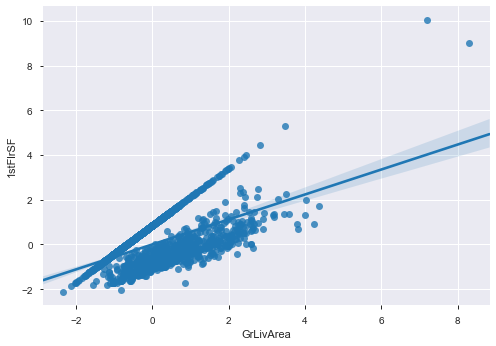

In [118]:
sns.regplot(x = 'GrLivArea',
            y = '1stFlrSF',
            data = housing_profile)

In [119]:
housing_profile['GrLivArea'].describe()

count    2.022000e+03
mean    -6.671221e-17
std      1.000000e+00
min     -2.327661e+00
25%     -7.415647e-01
50%     -1.097296e-01
75%      4.640287e-01
max      8.302388e+00
Name: GrLivArea, dtype: float64

In [120]:
housing_profile.describe()\
               .T\
               .sort_index()
                

,count,mean,std,min,25%,50%,75%,max
1stFlrSF,2022.0,-4.373356e-17,1.000000,-2.115632,-0.722993,-0.179601,0.610902,10.044583
2ndFlrSF,2022.0,3.283823e+02,425.261226,0.000000,0.000000,0.000000,689.000000,1862.000000
3SsnPorch,2022.0,2.628586e+00,25.408061,0.000000,0.000000,0.000000,0.000000,508.000000
BedroomAbvGr,2022.0,2.843719e+00,0.827118,0.000000,2.000000,3.000000,3.000000,8.000000
BsmtFinSF1,2022.0,4.423289e+02,460.683581,0.000000,0.000000,368.000000,733.000000,5644.000000
BsmtFinSF2,2022.0,4.823937e+01,165.681022,0.000000,0.000000,0.000000,0.000000,1474.000000
BsmtFullBath,2022.0,4.277943e-01,0.523074,0.000000,0.000000,0.000000,1.000000,3.000000
BsmtHalfBath,2022.0,6.429278e-02,0.253273,0.000000,0.000000,0.000000,0.000000,2.000000
BsmtUnfSF,2022.0,5.652418e+02,443.522453,0.000000,220.000000,473.500000,808.750000,2336.000000
EnclosedPorch,2022.0,2.259298e+01,59.811075,0.000000,0.000000,0.000000,0.000000,432.000000


In [121]:
categoricals = data_dict_populated.set_index(keys = 'attribute',
                                             drop = False)\
                                  .sort_index(axis = 0)\
                                  .set_index(keys = 'cat_vars',
                                             drop = False)\
                                  .loc['Categorical', 'attribute']\
                                  .tolist()
categorical_paritions = partition_list(parted_list = categoricals,
                                       partition_counts = 3)
influential_categoricals = ['BsmtQual', 'Central_Air', 'Condition_2',
                            'Fireplace_Qu', 'Kitchen_Qual', 'MS_Zoning',
                            'Overall_Cond', 'Overall_Qual', 'Street']

In [122]:
## 🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳ ##
categ_by_price = dict()
cat_var = categoricals[0]
for cat_var in categoricals:
    cat_log_fit = LogisticRegression(multi_class = 'multinomial',
                                     solver = 'lbfgs')
    cat_log_fit.fit(X = housing_profile[['SalePrice']],
                    y = housing_profile[cat_var])
    categ_by_price.update({cat_var : cat_log_fit.score(X = housing_profile[['SalePrice']],
                                                       y = housing_profile[cat_var])})
influential_categoricals = [key
                            for (key, val) in categ_by_price.items()
                            if val >= 0.65]

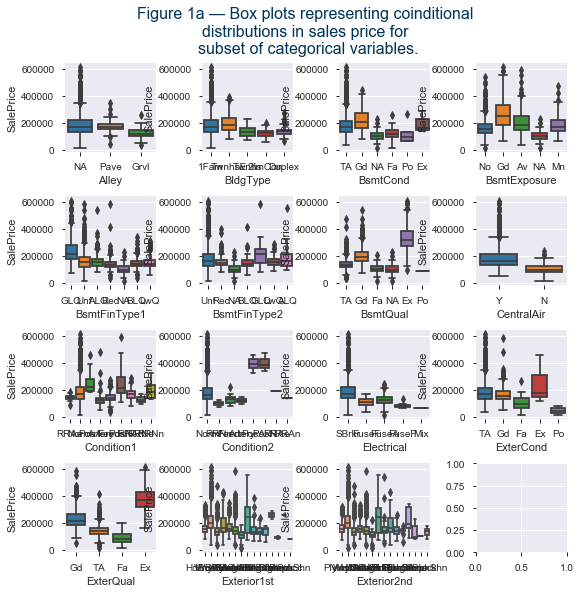

In [123]:
fig, axes = plt.subplots(int(np.ceil(np.sqrt(len(categorical_paritions.get(0))))),
                         int(np.ceil(np.sqrt(len(categorical_paritions.get(0))))),
                         figsize = (9,9))
plt_axis = dict(enumerate(np.ndarray.flatten(axes)))
cat_vars = dict(enumerate(categorical_paritions.get(0)))

for axis_idx in cat_vars.keys():
    sns.boxplot(y = housing_profile['SalePrice'],
                x = housing_profile[cat_vars.get(axis_idx)],
                ax = plt_axis.get(axis_idx))

fig.subplots_adjust(wspace = 0.5)
fig.subplots_adjust(hspace = 0.5)

plt.suptitle(t = 'Figure 1a — Box plots representing coinditional \n' +\
                   'distributions in sales price for \n' +\
                   'subset of categorical variables.',
             va = 'top',
             y = .9675,
             color = '#003459',
             fontsize = 16);



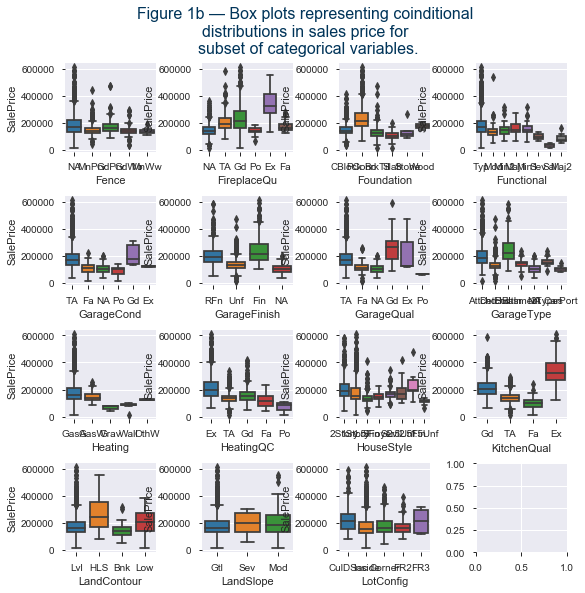

In [124]:
fig, axes = plt.subplots(int(np.ceil(np.sqrt(len(categorical_paritions.get(1))))),
                         int(np.ceil(np.sqrt(len(categorical_paritions.get(1))))),
                         figsize = (9,9))
plt_axis = dict(enumerate(np.ndarray.flatten(axes)))
cat_vars = dict(enumerate(categorical_paritions.get(1)))

for axis_idx in cat_vars.keys():
    sns.boxplot(y = housing_profile['SalePrice'],
                x = housing_profile[cat_vars.get(axis_idx)],
                ax = plt_axis.get(axis_idx))

fig.subplots_adjust(wspace = 0.5)
fig.subplots_adjust(hspace = 0.5)

plt.suptitle(t = 'Figure 1b — Box plots representing coinditional \n' +\
                   'distributions in sales price for \n' +\
                   'subset of categorical variables.',
             va = 'top',
             y = .9675,
             color = '#003459',
             fontsize = 16);



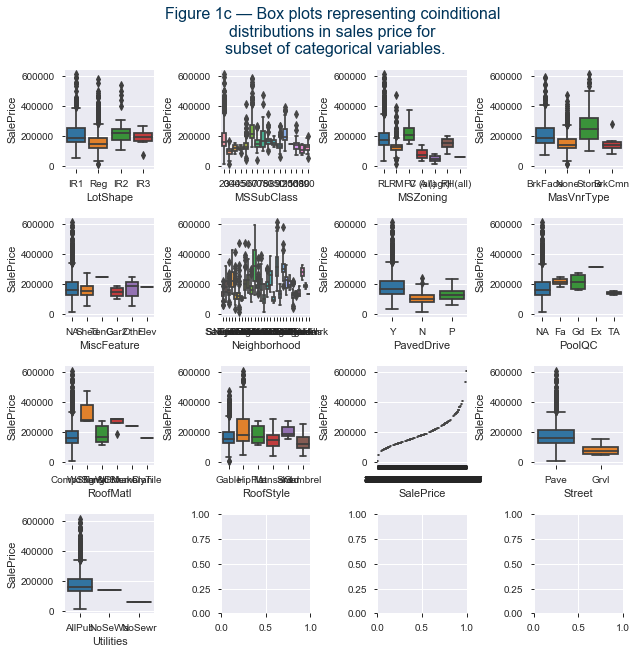

In [125]:
fig, axes = plt.subplots(int(np.ceil(np.sqrt(len(categorical_paritions.get(2))))),
                         int(np.ceil(np.sqrt(len(categorical_paritions.get(2))))),
                         figsize = (10, 10))
plt_axis = dict(enumerate(np.ndarray.flatten(axes)))
cat_vars = dict(enumerate(categorical_paritions.get(2)))

for axis_idx in cat_vars.keys():
    sns.boxplot(y = housing_profile['SalePrice'],
                x = housing_profile[cat_vars.get(axis_idx)],
                ax = plt_axis.get(axis_idx))

fig.subplots_adjust(wspace = 0.75)
fig.subplots_adjust(hspace = 0.5)

plt.suptitle(t = 'Figure 1c — Box plots representing coinditional \n' +\
                   'distributions in sales price for \n' +\
                   'subset of categorical variables.',
             va = 'top',
             y = .9675,
             color = '#003459',
             fontsize = 16);

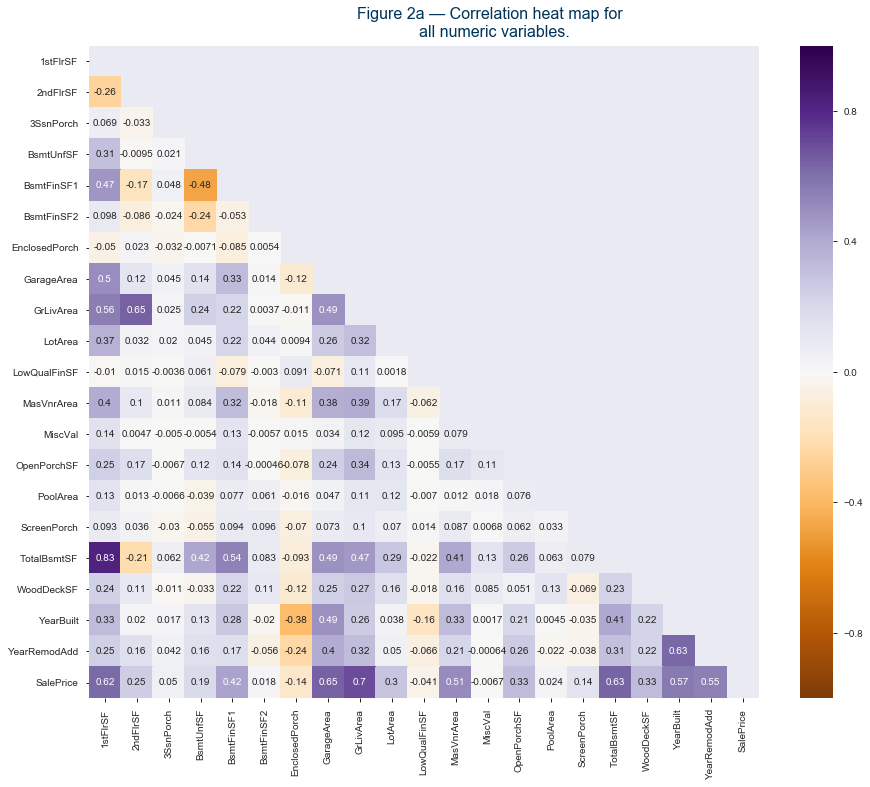

In [158]:
numericals =data_dict_populated.loc[['Discard attribute.' not in dispos
                                         for dispos in data_dict_populated['Disposition']]]\
                                .set_index(keys = 'cat_vars')\
                                .loc['Continuous', 'attribute']\
                                .tolist()
plt.figure(figsize=(15,12))
numericals_corr = housing_profile[numericals + ['SalePrice']].corr()

mask = np.zeros_like(numericals_corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data = numericals_corr,
            cmap = 'PuOr',
            vmin = -1,
            vmax = 1,
            mask = mask,
            annot = True)
plt.suptitle(t = 'Figure 2a — Correlation heat map for  \n'+\
                   'all numeric variables.',
             va = 'top',
             y = .925,
             color = '#003459',
             fontsize = 16);

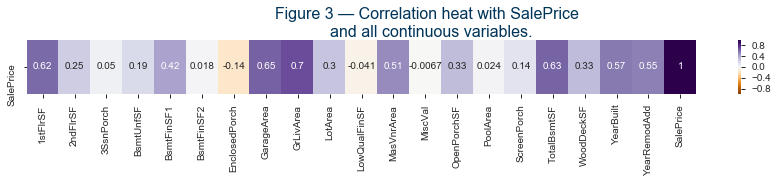

In [163]:
plt.figure(figsize=(15,1))
sns.heatmap(data = housing_profile[numericals + ['SalePrice']]\
                                  .corr()\
                                  .loc[['SalePrice']],
            cmap = 'PuOr',
            vmin = -1,
            vmax = 1,
            annot = True)
plt.suptitle(t = 'Figure 3 — Correlation heat with SalePrice  \n'+\
                   'and all continuous variables.',
             va = 'top',
             y = 1.333,
             color = '#003459',
             fontsize = 16);

In [128]:
# sns.pairplot(data =  housing_profile[numericals + ['SalePrice']])

In [129]:
numericals
cont_correlate_slope = dict()
for correlate in numericals:
    correlate_ols = LinearRegression(normalize = True)
    correlate_ols.fit(X = housing_profile[[correlate]],
                      y = housing_profile['SalePrice'])
    cont_correlate_slope.update({correlate : correlate_ols.coef_.item(0)})
cont_correlate_slope

{'1stFlrSF': 49366.59482565419,
 '2ndFlrSF': 46.846455712893764,
 '3SsnPorch': 155.7947688506856,
 'BsmtUnfSF': 33.85314064318834,
 'BsmtFinSF1': 72.96204287356771,
 'BsmtFinSF2': 8.554461793510859,
 'EnclosedPorch': -182.22158725985997,
 'GarageArea': 51320.06534799286,
 'GrLivArea': 55339.32641381392,
 'LotArea': 3.4890974049767296,
 'LowQualFinSF': -63.173013543981185,
 'MasVnrArea': 231.5912914991029,
 'MiscVal': -0.9162200491611988,
 'OpenPorchSF': 391.13591000569835,
 'PoolArea': 49.580229328772084,
 'ScreenPorch': 189.44280051264266,
 'TotalBsmtSF': 50101.489141321166,
 'WoodDeckSF': 202.15722127362957,
 'YearBuilt': 45239.54877082272,
 'YearRemodAdd': 43458.14830185147}

In [130]:
## 🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳ ##

sales_price_cont_corr = housing_profile[numericals + ['SalePrice']]\
                                      .corr()\
                                      .loc['SalePrice']
influental_continuous = sales_price_cont_corr.loc[(np.abs(sales_price_cont_corr) >= 0.5) &\
                                                   (np.abs(sales_price_cont_corr) != 1)].index.tolist()
influental_continuous

['1stFlrSF',
 'GarageArea',
 'GrLivArea',
 'MasVnrArea',
 'TotalBsmtSF',
 'YearBuilt',
 'YearRemodAdd']

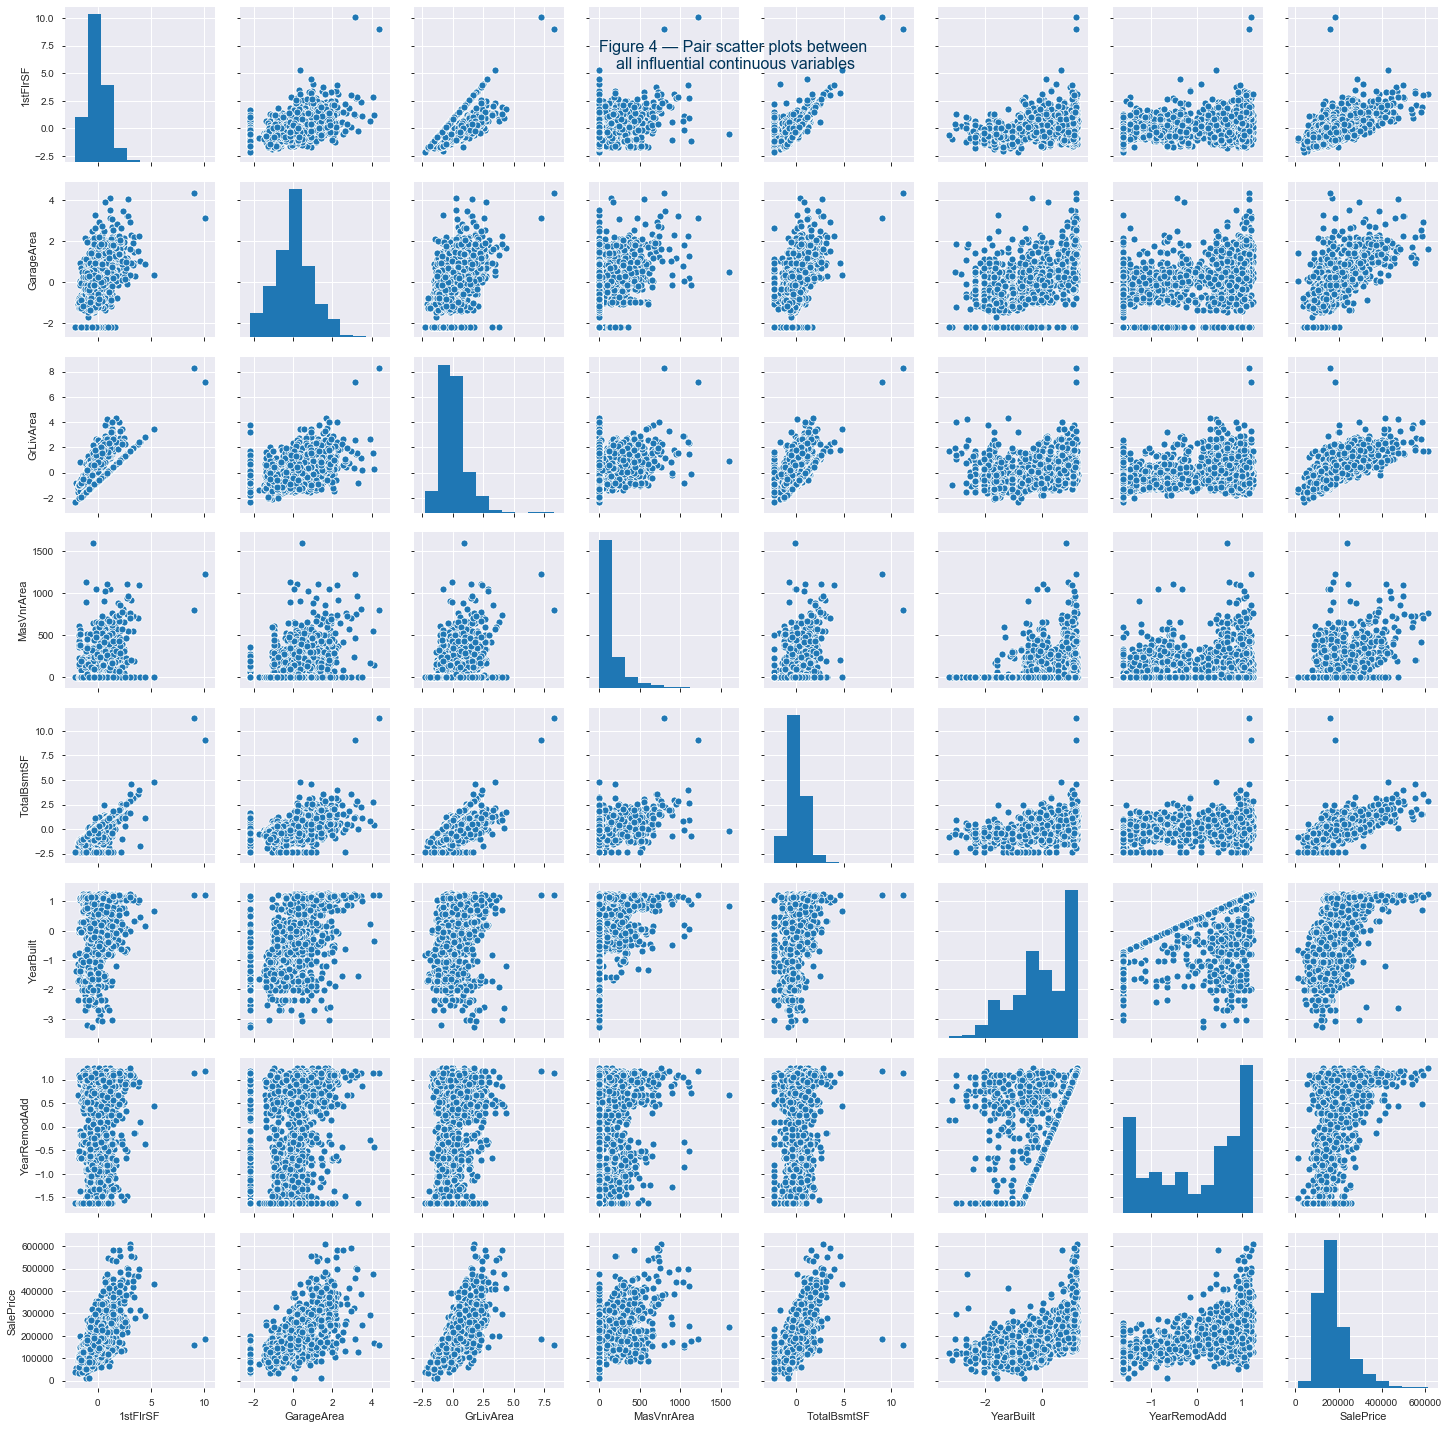

In [164]:
sns.pairplot(data = housing_profile[influental_continuous +  ['SalePrice']])
plt.suptitle(t = 'Figure 4 — Pair scatter plots between \n' +\
                   'all influential continuous variables',
             va = 'top',
             y = .9675,
             color = '#003459',
             fontsize = 16);

In [133]:
discretes = data_dict_populated.set_index(keys = 'attribute',
                                                  drop = False)\
                                .drop(labels = ['Id', 'PID', 'SalePrice'] +\
                                                discarded_attributes)\
                                .sort_index()\
                                .set_index(keys = 'cat_vars',
                                           drop = False)\
                                .loc['Discrete', 'attribute']\
                                .tolist()

discretes

['BedroomAbvGr',
 'BsmtFullBath',
 'BsmtHalfBath',
 'Fireplaces',
 'FullBath',
 'GarageCars',
 'HalfBath',
 'KitchenAbvGr',
 'OverallCond',
 'OverallQual',
 'TotRmsAbvGrd']

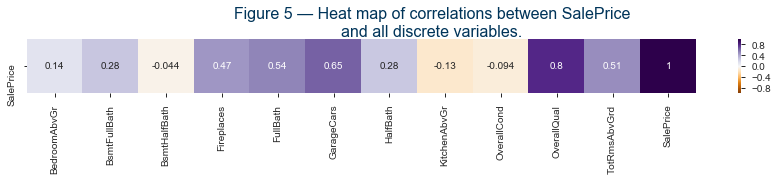

In [165]:
discretes
plt.figure(figsize=(15,1))
sns.heatmap(data = housing_profile[discretes + ['SalePrice']]\
                                  .corr()\
                                  .loc[['SalePrice']],
            cmap = 'PuOr',
            vmin = -1,
            vmax = 1,
            annot = True)
plt.suptitle(t = 'Figure 5 — Heat map of correlations between SalePrice\n'+\
                   'and all discrete variables.',
             va = 'top',
             y = 1.333,
             color = '#003459',
             fontsize = 16);

In [136]:
## 🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳ ##

sales_price_discr_corr = housing_profile[discretes + ['SalePrice']]\
                                      .corr()\
                                      .loc['SalePrice']
influental_discretes = sales_price_discr_corr.loc[(np.abs(sales_price_discr_corr) >= 0.5) &\
                                                   (np.abs(sales_price_discr_corr) != 1)].index.tolist()
influental_discretes

['FullBath', 'GarageCars', 'OverallQual', 'TotRmsAbvGrd']

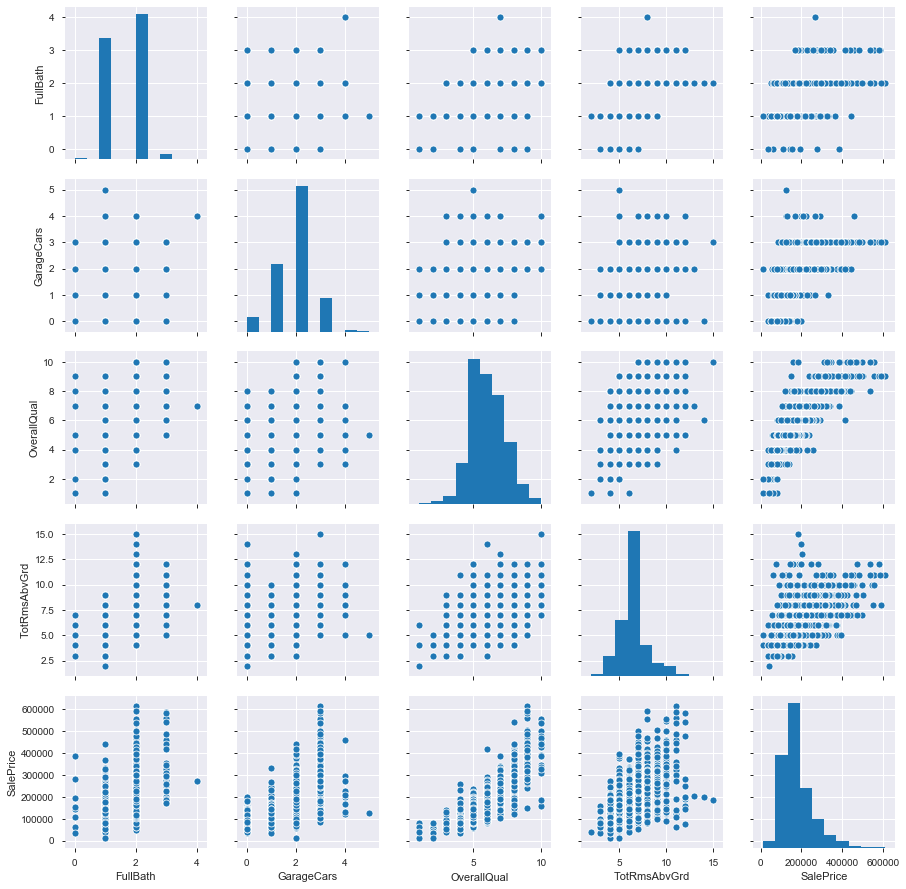

In [166]:
sns.pairplot(data =  housing_profile[influental_discretes + ['SalePrice']])

In [137]:
# discrete_by_price = dict()
# cat_var = categoricals[0]
# for disc_var in discretes:
#     disc_log_fit = LogisticRegression(multi_class = 'multinomial',
#                                       solver = 'lbfgs')
#     disc_log_fit.fit(X = housing_profile[['SalePrice']],
#                      y = housing_profile[disc_var])
#     discrete_by_price.update({disc_var : disc_log_fit.score(X = housing_profile[['SalePrice']],
#                                                             y = housing_profile[disc_var])})
# [key
#                             for (key, val) in discrete_by_price.items()
#                             if val >= 0.5]

In [188]:
## 🐫🐪🐘🐃🐎🐶🐫🐪🐘🐃🐎🐶🐫🐪🐘🐃🐎🐶🐫🐪🐘🐃🐎🐶🐫🐪🐘🐃🐎🐶🐫🐪🐘🐃🐎🐶🐫🐪🐘🐃🐎🐶 ##
sac_house_model_mtx = pd.get_dummies(
                        data = housing_profile[influential_categoricals +\
                                               influental_continuous +\
                                               influental_discretes +\
                                               ['SalePrice']]\
                                              .assign(size_qual = lambda Ξ : Ξ['GrLivArea'] * Ξ['OverallQual']),
                        columns = influential_categoricals,
                        drop_first = True)

numeric_poly = PolynomialFeatures(degree = 2,
                                  interaction_only = False,
                                  include_bias = False)

sac_house_model_mtx =\
pd.merge(right = pd.DataFrame(data = numeric_poly.fit_transform(sac_house_model_mtx[influental_continuous +\
                                                                                   influental_discretes]),
                             columns = numeric_poly.get_feature_names(influental_continuous +\
                                                                      influental_discretes),
                             index = sac_house_model_mtx.index),
         left = sac_house_model_mtx,
         left_index = True,
         right_index = True)



In [189]:
sac_house_model_ttl_init = dict(zip(['X_train', 'X_test', 'y_train', 'y_test'],
                                       train_test_split(sac_house_model_mtx.drop(labels = 'SalePrice',
                                                                                 axis = 1),
                                                        sac_house_model_mtx['SalePrice'],
                                                        test_size = 0.25,
                                                        random_state = 123)))
sac_house_scaler = StandardScaler()
sac_house_scaler.fit(sac_house_model_ttl_init.get('X_train'))
sac_house_model_ttl_init.update(
    {'X_train_scale' : pd.DataFrame(data = sac_house_scaler.transform(sac_house_model_ttl_init.get('X_train')),
                                    columns = sac_house_model_ttl_init.get('X_train').columns,
                                    index = sac_house_model_ttl_init.get('X_train').index),
     'X_test_scale' : pd.DataFrame(data = sac_house_scaler.transform(sac_house_model_ttl_init.get('X_test')),
                                    columns = sac_house_model_ttl_init.get('X_test').columns,
                                    index = sac_house_model_ttl_init.get('X_test').index)})

In [195]:
sac_house_ridge_cv = RidgeCV(alphas = np.logspace(start = 1,
                                                 stop = 2.5,
                                                 num = 100),
                            scoring = 'r2',
                            cv = 5)
sac_house_ridge_cv.fit(X = sac_house_model_ttl_init.get('X_train_scale'),
                       y = sac_house_model_ttl_init.get('y_train'))
α_ridge = sac_house_ridge_cv.alpha_
train_R2 = sac_house_ridge_cv.score(X = sac_house_model_ttl_init.get('X_train_scale'),
                                   y = sac_house_model_ttl_init.get('y_train'))
test_R2 = sac_house_ridge_cv.score(X = sac_house_model_ttl_init.get('X_test_scale'),
                                   y = sac_house_model_ttl_init.get('y_test'))
print('optimum ridge α = {} \n Train R² : {} \n Test R² : {}'.format(α_ridge, train_R2, test_R2))
sac_house_model_ttl_init.update(
    {'fit_train_ridge' : sac_house_ridge_cv.predict(X = sac_house_model_ttl_init.get('X_train_scale')),
     'fit_test_ridge' : sac_house_ridge_cv.predict(X = sac_house_model_ttl_init.get('X_test_scale'))})
sac_house_model_ttl_init.update(
    {'resid_train_ridge' : sac_house_model_ttl_init.get('y_train') - sac_house_model_ttl_init.get('fit_train_ridge'),
     'resid_test_ridge' : sac_house_model_ttl_init.get('y_test') - sac_house_model_ttl_init.get('fit_test_ridge')})

optimum ridge α = 316.22776601683796 
 Train R² : 0.9072271342515991 
 Test R² : 0.8577339213342073


In [196]:
sac_house_lasso_cv = ElasticNetCV(alphas = np.logspace(start = 0.5,
                                                         stop = 1,
                                                         num = 100),
                                  cv = 5,
                                  l1_ratio = 0.5)
sac_house_lasso_cv.fit(X = sac_house_model_ttl_init.get('X_train_scale'),
                       y = sac_house_model_ttl_init.get('y_train'))
α_lasso = sac_house_lasso_cv.alpha_
train_R2 = sac_house_lasso_cv.score(X = sac_house_model_ttl_init.get('X_train_scale'),
                                   y = sac_house_model_ttl_init.get('y_train'))
test_R2 = sac_house_lasso_cv.score(X = sac_house_model_ttl_init.get('X_test_scale'),
                                   y = sac_house_model_ttl_init.get('y_test'))
print('optimum lasso α = {} \n Train R² : {} \n Test R² : {}'.format(α_lasso, train_R2, test_R2))
sac_house_model_ttl_init.update(
    {'fit_train_lasso' : sac_house_ridge_cv.predict(X = sac_house_model_ttl_init.get('X_train_scale')),
     'fit_test_lasso' : sac_house_ridge_cv.predict(X = sac_house_model_ttl_init.get('X_test_scale'))})
sac_house_model_ttl_init.update(
    {'resid_train_lasso' : sac_house_model_ttl_init.get('y_train') - sac_house_model_ttl_init.get('fit_train_lasso'),
     'resid_test_lasso' : sac_house_model_ttl_init.get('y_test') - sac_house_model_ttl_init.get('fit_test_lasso')})

optimum lasso α = 3.1622776601683795 
 Train R² : 0.8770078531460709 
 Test R² : 0.8374732989277285


In [197]:
sac_house_enet_cv = ElasticNetCV(alphas = np.logspace(start = 0.5,
                                                         stop = 1,
                                                         num = 100),
                                  cv = 5,
                                  l1_ratio = 0.85)
sac_house_enet_cv.fit(X = sac_house_model_ttl_init.get('X_train_scale'),
                       y = sac_house_model_ttl_init.get('y_train'))
α_elnet = sac_house_enet_cv.alpha_
train_R2 = sac_house_enet_cv.score(X = sac_house_model_ttl_init.get('X_train_scale'),
                                   y = sac_house_model_ttl_init.get('y_train'))
test_R2 = sac_house_enet_cv.score(X = sac_house_model_ttl_init.get('X_test_scale'),
                                   y = sac_house_model_ttl_init.get('y_test'))
print('optimum ElasticNet α = {} \n Train R² : {} \n Test R² : {}'.format(α_elnet, train_R2, test_R2))
sac_house_model_ttl_init.update(
    {'fit_train_elnet' : sac_house_enet_cv.predict(X = sac_house_model_ttl_init.get('X_train_scale')),
     'fit_test_elnet' : sac_house_enet_cv.predict(X = sac_house_model_ttl_init.get('X_test_scale'))})
sac_house_model_ttl_init.update(
    {'resid_train_elnet' : sac_house_model_ttl_init.get('y_train') - sac_house_model_ttl_init.get('fit_train_elnet'),
     'resid_test_elnet' : sac_house_model_ttl_init.get('y_test') - sac_house_model_ttl_init.get('fit_test_elnet')})

optimum ElasticNet α = 4.180344961851454 
 Train R² : 0.895875487297379 
 Test R² : 0.8574367115887077


In [210]:
sac_house_model_ols_init.summary()

NotImplementedError: 

In [203]:
sac_house_model_ols_init = sm.OLS(sac_house_model_ttl_init.get('y_train'),
                                  sac_house_model_ttl_init.get('X_train'))\
                             .fit_regularized(method = 'elastic_net',
                                              alpha = α_ridge,
                                              L1_wt = 0)
ols_init_summy = fct.reduce(lambda Ξ, Ζ : pd.merge(left = Ξ,
                                                   right = Ζ,
                                                   left_index = True,
                                                   right_index = True),
                                            [pd.DataFrame(data = sac_house_model_ols_init.params,
                                                         columns = ['coefficients']),
                                            pd.DataFrame(data = sac_house_model_ols_init.pvalues,
                                                         columns = ['p_values']),
                                            sac_house_model_ols_init.conf_int(alpha = 0.05)\
                                                                     .rename(columns = {0 : 'lower_bound',
                                                                                        1 : 'upper_bound'})])
sac_house_model_ttl_init.update(
    {'fit_train' : sac_house_model_ols_init.fit().predict(sac_house_model_ttl_init.get('X_train')),
     'fit_test' : sac_house_model_ols_init.fit().predict(sac_house_model_ttl_init.get('X_test'))})
sac_house_model_ttl_init.update(
    {'resid_train' : sac_house_model_ttl_init.get('y_train') - sac_house_model_ttl_init.get('fit_train'),
     'resid_test' : sac_house_model_ttl_init.get('y_test') - sac_house_model_ttl_init.get('fit_test')})

AttributeError: 'RegularizedResults' object has no attribute 'pvalues'

array([ 1.31457357e+01,  3.05739442e+00, -1.01900474e+01,  1.23005915e+02,
        1.43271899e+01,  8.01981859e+00,  6.79796339e+00,  5.21913223e+01,
        6.65437400e+01,  2.20589443e+02,  1.92869588e+02, -1.66518333e+01,
        3.94613773e+01, -1.32778561e-01, -9.72126321e-02, -2.93690411e+00,
       -1.43007573e+00,  3.17296817e+00, -8.80958135e-01,  2.65614305e+00,
        6.60003793e-02,  5.54226464e-02,  3.73255556e+01,  1.16520061e+01,
        3.64264319e+00,  6.60003794e-02,  1.81615743e+01,  1.93625929e+00,
        1.52484321e+00,  2.13531218e+00,  6.60003793e-02,  2.42795867e+00,
        2.95418557e+01,  4.01717797e+01,  1.09288257e+00,  3.65547712e+01,
        5.94330570e-01,  1.06909435e+00,  6.03824566e-01, -1.01032164e-01,
       -6.61487798e-02, -1.22028391e-01, -4.97239016e-02,  3.94158981e+01,
        1.38315296e-01,  1.78261054e-02, -1.30802107e-01, -7.01033101e-02,
        8.78245337e-02,  6.33227767e-02, -1.02126013e-01, -8.15930551e-02,
        3.69785410e+01, -

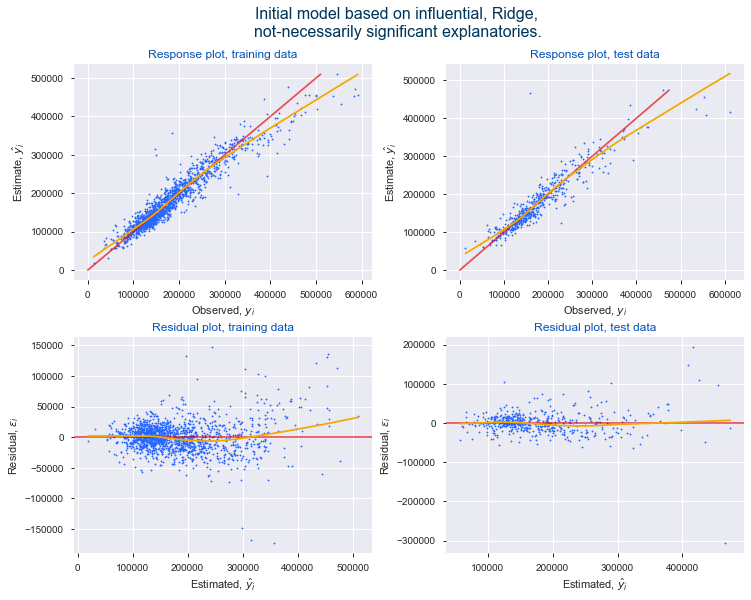

In [198]:
response_residual_plots(y_test = sac_house_model_ttl_init.get('y_test'),
                        y_train = sac_house_model_ttl_init.get('y_train'), 
                        fit_test = sac_house_model_ttl_init.get('fit_test_ridge'), 
                        fit_train = sac_house_model_ttl_init.get('fit_train_ridge'), 
                        plot_title = 'Initial model based on influential, Ridge, \n' +\
                                      'not-necessarily significant explanatories.')

In [ ]:
𝝱_signficant = ols_init_summy.loc[ols_init_summy['p_values'] <= 0.05].index
sac_house_model_ttl_2 = deepcopy(sac_house_model_ttl_init)
sac_house_model_ttl_2.update({'X_train' : sac_house_model_ttl_2.get('X_train')[𝝱_signficant],
                              'X_test' : sac_house_model_ttl_2.get('X_test')[𝝱_signficant]})
sac_house_model_ols_2 = sm.OLS(sac_house_model_ttl_2.get('y_train'),
                               sac_house_model_ttl_2.get('X_train'))
ols_2_summy = fct.reduce(lambda Ξ, Ζ : pd.merge(left = Ξ,
                                                   right = Ζ,
                                                   left_index = True,
                                                   right_index = True),
                                            [pd.DataFrame(data = sac_house_model_ols_2.fit().params,
                                                         columns = ['coefficients']),
                                            pd.DataFrame(data = sac_house_model_ols_2.fit().pvalues,
                                                         columns = ['p_values']),
                                            sac_house_model_ols_2.fit().conf_int(alpha = 0.05)\
                                                                       .rename(columns = {0 : 'lower_bound',
                                                                                          1 : 'upper_bound'})])
sac_house_model_ttl_2.update(
    {'fit_train' : sac_house_model_ols_2.fit().predict(sac_house_model_ttl_2.get('X_train')),
     'fit_test' : sac_house_model_ols_2.fit().predict(sac_house_model_ttl_2.get('X_test'))})
sac_house_model_ttl_2.update(
    {'resid_train' : sac_house_model_ttl_2.get('y_train') - sac_house_model_ttl_2.get('fit_train'),
     'resid_test' : sac_house_model_ttl_2.get('y_test') - sac_house_model_ttl_2.get('fit_test')})


In [ ]:
anova(y_observed = sac_house_model_ttl_2.get('y_train'),
      y_estimated = sac_house_model_ttl_2.get('fit_train'))

In [ ]:
anova(y_observed = sac_house_model_ttl_2.get('y_test'),
      y_estimated = sac_house_model_ttl_2.get('fit_test'))

In [ ]:

np.mean([val.get('R2')
 for (key, val) in manual_cross_val_anova(X = sac_house_model_ttl_2.get('X_train'), 
                                           y = sac_house_model_ttl_2.get('y_train'), 
                                           cv = 5).items()])

In [ ]:
response_residual_plots(y_test = sac_house_model_ttl_2.get('y_test'),
                        y_train = sac_house_model_ttl_2.get('y_train'), 
                        fit_test = sac_house_model_ttl_2.get('fit_test'), 
                        fit_train = sac_house_model_ttl_2.get('fit_train'), 
                        plot_title = 'Second model based on  influential, \n' +\
                                      'strictly significant explanatories.')

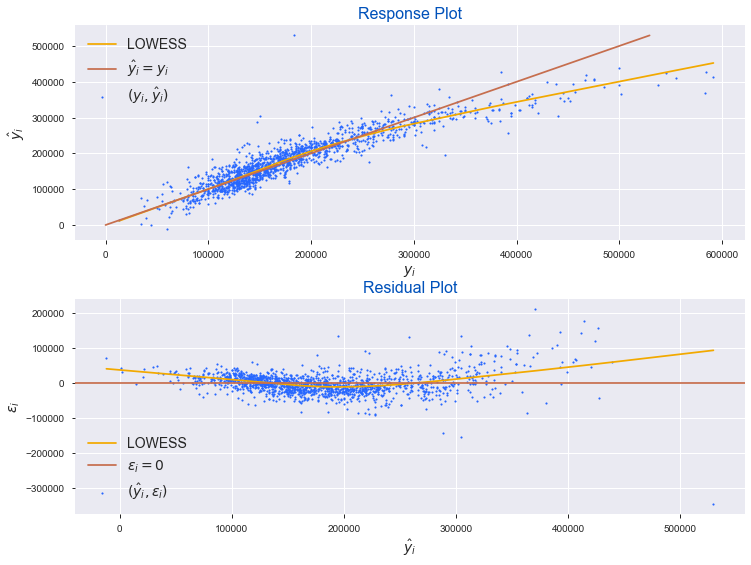

In [58]:
fig, axes = plt.subplots(2, 1, figsize = (12, 9))
resp_lowess = sm.nonparametric.lowess
resp_lowess_fit = resp_lowess(endog = sac_house_model_ttl_init.get('fit_train_ridge'),
                              exog = sac_house_model_ttl_init.get('y_train'))
axes[0].plot(resp_lowess_fit[:,0],
             resp_lowess_fit[:,1],
             color = '#f2a900',
             label = 'LOWESS')
axes[0].plot([0,min(max(sac_house_model_ttl_init.get('y_train')),
                    max(sac_house_model_ttl_init.get('fit_train_ridge')))],
             [0,min(max(sac_house_model_ttl_init.get('y_train')),
                    max(sac_house_model_ttl_init.get('fit_train_ridge')))],
             color = '#c66e4e',
             label = '$\hat{y}_i = y_i$')
axes[0].scatter(sac_house_model_ttl_init.get('y_train'),
                sac_house_model_ttl_init.get('fit_train_ridge'),
                color = '#2767ff',
                s = 3,
             label = '$ (y_i, \hat{y}_i)$')
axes[0].legend(loc = 'upper left',
               fontsize = 14)
axes[0].set_xlabel(xlabel = '$y_i$',
               fontsize = 14)
axes[0].set_ylabel(ylabel = '$\hat{y}_i$',
               fontsize = 14);
axes[0].set_title(label = 'Response Plot',
                  color = '#0051ba',
                  fontsize = 16)
axes[0].grid(True)


resid_lowess = sm.nonparametric.lowess
resid_lowess_fit = resp_lowess(exog = sac_house_model_ttl_init.get('fit_train'),
                              endog = sac_house_model_ttl_init.get('resid_train'))
axes[1].plot(resid_lowess_fit[:,0],
             resid_lowess_fit[:,1],
             color = '#f2a900',
             label = 'LOWESS')
axes[1].axhline(color = '#c66e4e',
                label = '$\epsilon_i = 0$')
axes[1].scatter(sac_house_model_ttl_init.get('fit_train'),
                sac_house_model_ttl_init.get('resid_train'),
                color = '#2767ff',
                s = 3,
             label = '$ (\hat{y}_i, \epsilon_i)$')
axes[1].legend(loc = 'lower left',
               fontsize = 14)
axes[1].set_xlabel(xlabel = '$\hat{y}_i$',
               fontsize = 14)
axes[1].set_ylabel(ylabel = '$\epsilon_i$',
               fontsize = 14);
axes[1].set_title(label = 'Residual Plot',
                  color = '#0051ba',
                  fontsize = 16)
fig.subplots_adjust(hspace = 0.275)

plt.savefig('Resp_resid.png',
        dpi = 150)